# Exploring Volatility Vs. Volume

#### Date: 07/03/2022
#### Author: Isaac Lee

## Question
Is there a correlation between volatility and volume for bitcoin?  
We look at the past 500 4hr candles.

In [90]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import my_data_pipelines as mdp

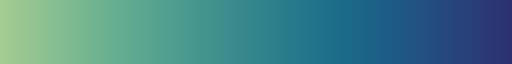

In [91]:
sns.set(rc={"figure.figsize":(25, 12)})
sns.set_context("poster")
palette = "crest"
sns.set_palette(palette=palette)
my_colors = ["#6CB190", "#1D2562"]
sns.color_palette(palette=palette, as_cmap=True)

In [92]:
original_df = pd.read_csv("USDT_BTC_price_2021.csv")

In [93]:
print(original_df.shape)
original_df.head(3)

(8759, 11)


,dateTime,volume,weightedAverage,close,high,low,open,year,month,day,hour
0,2021-01-01 01:00:00,2.425356e+06,29089.841123,29380.440148,29408.688724,28836.785612,28836.785612,2021,1,1,1
1,2021-01-01 02:00:00,2.034385e+06,29362.761295,29291.092506,29483.000000,29200.000000,29408.688725,2021,1,1,2
2,2021-01-01 03:00:00,9.532374e+05,29240.455726,29205.401343,29329.534816,29134.378297,29274.401102,2021,1,1,3


## Aggregating into 4hr candles and calculating volatility
So if our original dataframe has 1hr candles and we want the last num_candles 4hr candles, that means we are interested in the last 4*num_candles entries in our original dataframe.

In [94]:
num_candles = 250
n = num_candles * 4
original_df = original_df.tail(n)
original_df.shape

(2000, 11)

In [95]:
df = pd.DataFrame()
for i in range(0, n, 4):
    # Initialize our empty df to populate with values
    row_dict = {}

    # Take four entry slices of our dataframe and aggregate values
    four = original_df[i:i+4]
    # Note that we convert each entry to a list for compatability
    # with the pandas .from_dict() method
    row_dict['dateTime'] = [four.iloc[-1]['dateTime']]
    row_dict['volume'] = [four['volume'].sum()]
    row_dict['volatility'] = [four['close'].std()]
    row_dict['weightedAverage'] = [four['weightedAverage'].mean()]
    row_dict['close'] = [four['close'].iloc[-1]]
    row_dict['open'] = [four['open'].iloc[0]]
    row_dict['high'] = [max(four['high'])]
    row_dict['low'] = [min(four['low'])]

    # Append our current dataframe
    row_df = pd.DataFrame.from_dict(row_dict)
    df = pd.concat([df, row_df], ignore_index=True, axis=0)

In [96]:
print(f"Dataframe dimensions: {df.shape}")


Dataframe dimensions: (500, 8)


Nice! So now we have our aggregated df, we just quickly check to see
how clean the data is.

In [97]:
df.isna().sum()

dateTime           0
volume             0
volatility         0
weightedAverage    0
close              0
open               0
high               0
low                0
dtype: int64

For the last part of the data cleaning process we convert our
dateTime column to a datetime pandas Series:

In [98]:
df['dateTime'] = pd.to_datetime(df['dateTime'])

In [99]:
# Custom function to interactively scroll through the df
mdp.scroll_df(df)

interactive(children=(IntSlider(value=0, description='row_idx', max=499), Dropdown(description='Sort by', inde…

## Visualizing

### Candlestick Chart

In [100]:
layout = go.Layout(autosize=False, width=1500, height=800)
fig = go.Figure(data=[go.Candlestick(x=df['dateTime'],
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])],
               layout=layout)


fig.show()

## Volume Vs. Volatility

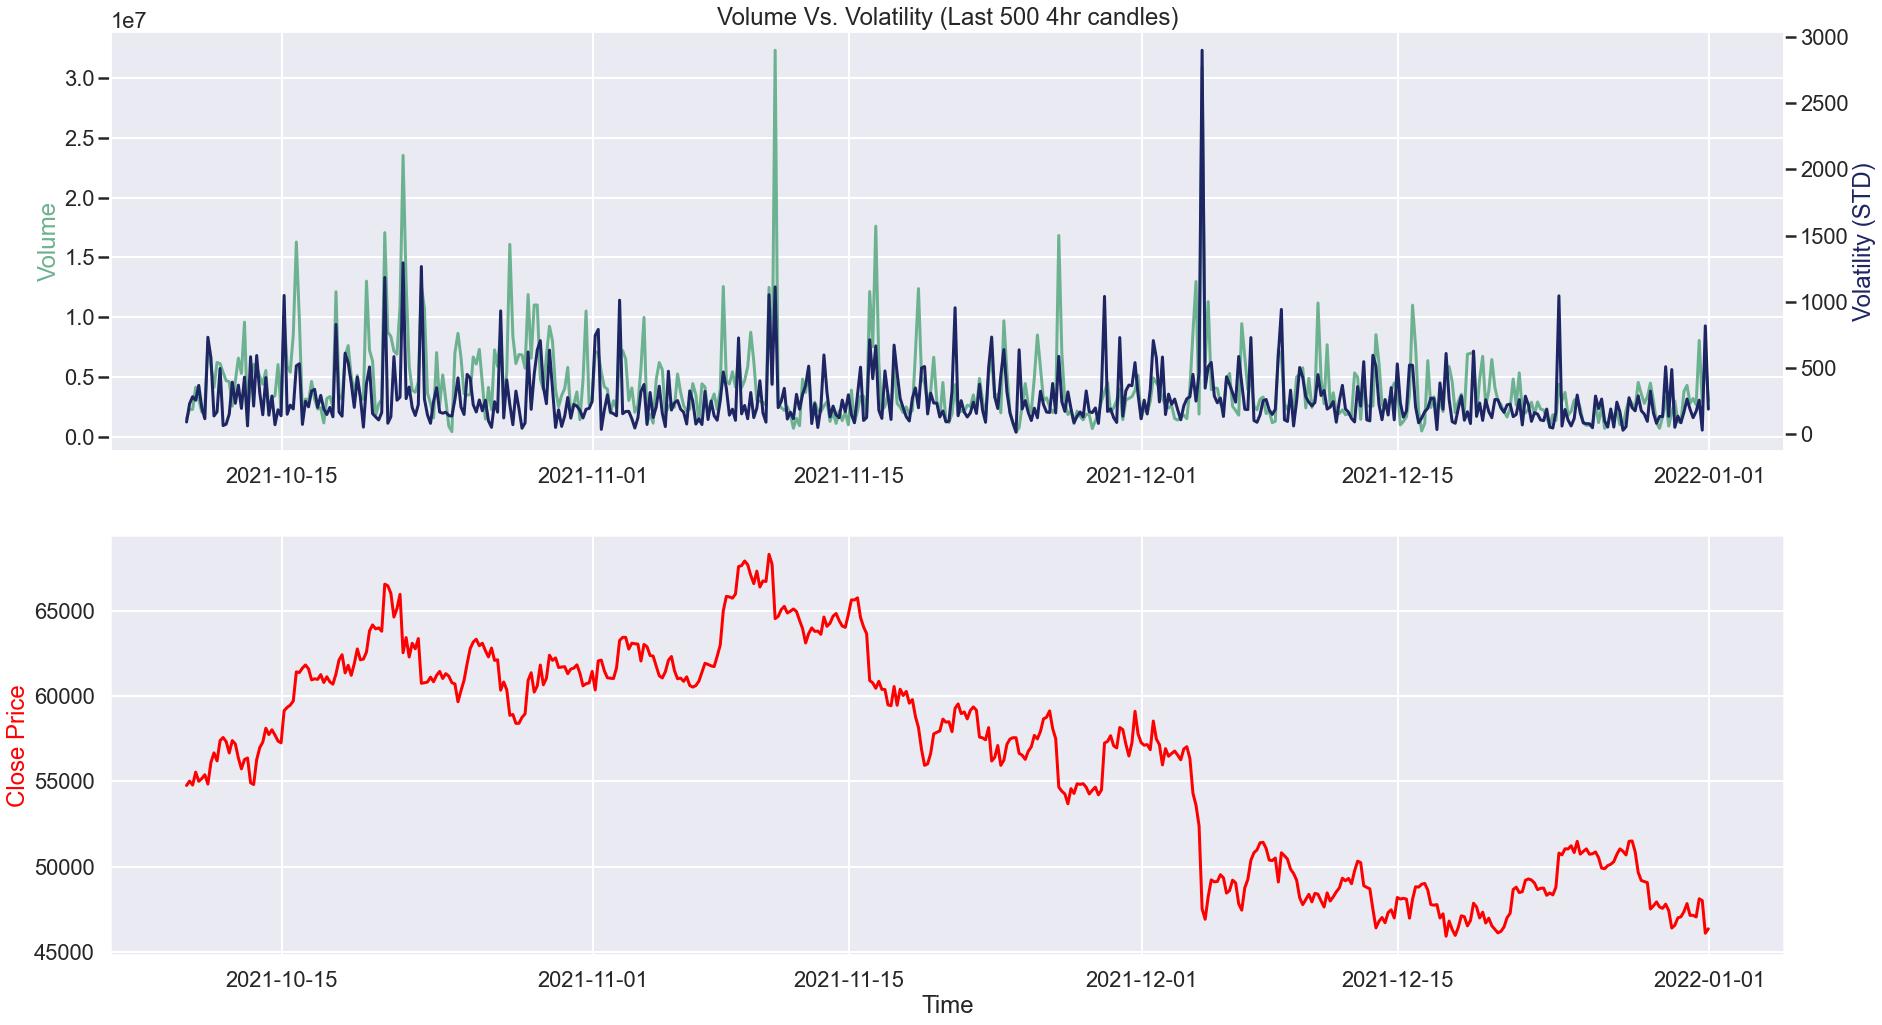

In [101]:
fig, ax = plt.subplots(2, 1, figsize=(30, 17)) # initializes figure and plots

ax2 = ax[0].twinx()
g1 = sns.lineplot(data=df, x='dateTime', y='volume', ax=ax[0], color=my_colors[0])
g2 = sns.lineplot(data=df, x='dateTime', y='volatility', ax=ax2, color=my_colors[1])
g3 = sns.lineplot(data=df, x='dateTime', y='close', ax=ax[1], color='red')

ax[0].set_xlabel('')
ax[0].set_ylabel('Volume', color=my_colors[0])
# ax[0].set_xlim([df.dateTime.iloc[0], df.dateTime.iloc[-1]])
ax2.set_ylabel('Volatility (STD)', color=my_colors[1])
ax2.grid(False)
ax[1].set_ylabel('Close Price', color='red')
ax[1].set_xlabel('Time')
# ax[1].set_xlim([df.dateTime.iloc[0], df.dateTime.iloc[-1]])
plt.title(f"Volume Vs. Volatility (Last {num_candles} 4hr candles)")

plt.savefig(f'USDT_BTC_volume_vs_volatility_last_{num_candles}_candles.png')
plt.show()

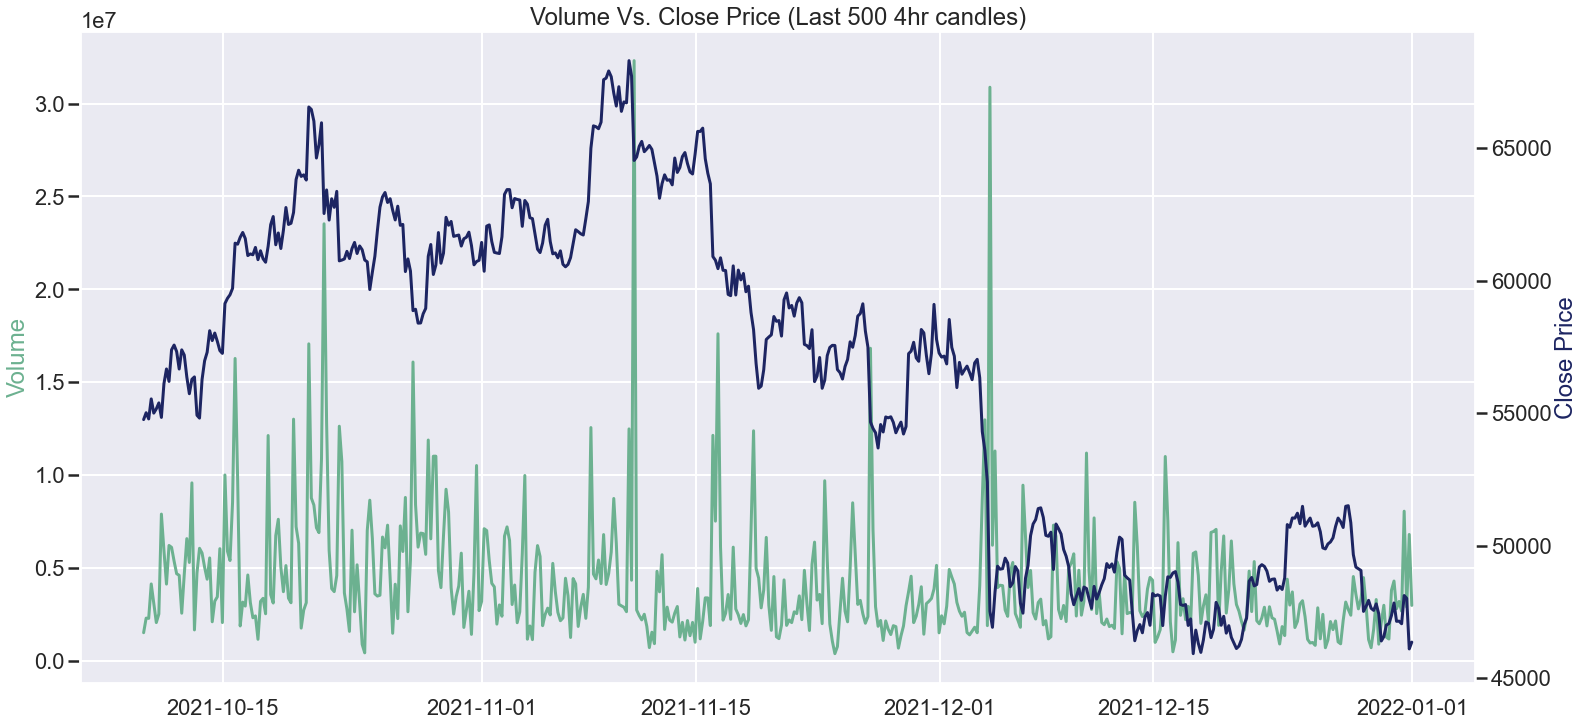

In [102]:
fig, ax1 = plt.subplots() # initializes figure and plots

ax2 = ax1.twinx()
sns.lineplot(data=df, x='dateTime', y='volume', ax=ax1, color=my_colors[0])
sns.lineplot(data=df, x='dateTime', y='close', ax=ax2, color=my_colors[1])

ax1.set_xlabel('')
ax1.set_ylabel('Volume', color=my_colors[0])
# ax1.set_xlim([df.dateTime.iloc[0], df.dateTime.iloc[-1]])
# ax2.set_xlim([df.dateTime.iloc[0], df.dateTime.iloc[-1]])
ax2.set_ylabel('Close Price', color=my_colors[1])
ax2.grid(False)
plt.title(f"Volume Vs. Close Price (Last {num_candles} 4hr candles)")

plt.savefig(f'USDT_BTC_volume_vs_close_last_{num_candles}_candles.png')
plt.show()